# Big G Express: Predicting Derates
In this project, you will be working with fault code data and vehicle onboard diagnostic data to try and predict an upcoming full derate. These are indicated by an SPN 5246. 

You have been provided with a two files containing the data you will use to make these predictions (J1939Faults.csv and VehicleDiagnosticOnboardData.csv) as well as two files describing some of the contents (DataInfo.docx and Service Fault Codes_1_0_0_167.xlsx) 

Note that in its raw form the data does not have "labels", so you must define what labels you are going to use and create those labels in your dataset. Also, you will likely need to perform some significant feature engineering in order to build an accurate predictor.

There are service locations at (36.0666667, -86.4347222), (35.5883333, -86.4438888), and (36.1950, -83.174722), so you should remove any records in the vicinity of these locations, as fault codes may be tripped when working on the vehicles.

When evaluating the performance of your model, assume that the cost associated with a missed full derate is approximately $4000.00$ in towing and repairs, and the cost of a false positive prediction is about $500 due to having the truck off the road and serviced unnecessarily.

##### Why Derate?
A derate is designed to protect you from causing engine or DPF damage. A derate can be caused by various sensors or systems. However, when it's a specific 5 MPH derate then you can be certain that the problem is related to the emissions, aka the aftertreatment system.

ref:
https://otrperformance.com/blogs/quick-tips/your-cummins-has-a-5-mph-def-derate-spn-5246-what-now

A failed component is usually what triggers this code.

Common Failures

 * Failed DEF doser valve
 * Associated fault code: SPN 5394
 * You ran out of DEF fluid
 * Associated fault code: SPN 5392, SPN 1761
 * Inlet and Outlet NOx sensors failed, not making pressure
 * Associated fault code: SPN 4094
 * EGR system malfunction causing NOX efficiency problems
 * DEF pump failed, not making pressure
 * Associated fault code: SPN 4334, SPN 4339
 * DEF module has failed or DEF harness failure or no power to DEF module causes DEF gauge to be empty and showing datalink error and SCR malfunction.
 * The DEF / ECM could also need updating to eliminate ghost codes.

#### Data exploration

In [31]:
import pandas as pd
import numpy as np
import missingno as msno 

J1939Faults.csv
* Contains information about whether a fault light is going on (active = True) or turning off (active = False)
* Each fault has an spn + fmi
* SPN = Suspect Parameter Number
* FMI = Failure-Mode Indicator
* We will be most interested in partial derates (spn-fmi = 1569-31) and full derates (spn = 5246)

In [2]:
faults = pd.read_csv("../data/J1939Faults.csv", low_memory=False)
faults.head()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000


In [3]:
faults.shape 

(1187335, 20)

In [4]:
faults.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   RecordID               1187335 non-null  int64  
 1   ESS_Id                 1187335 non-null  int64  
 2   EventTimeStamp         1187335 non-null  object 
 3   eventDescription       1126490 non-null  object 
 4   actionDescription      0 non-null        float64
 5   ecuSoftwareVersion     891285 non-null   object 
 6   ecuSerialNumber        844318 non-null   object 
 7   ecuModel               1122577 non-null  object 
 8   ecuMake                1122577 non-null  object 
 9   ecuSource              1187335 non-null  int64  
 10  spn                    1187335 non-null  int64  
 11  fmi                    1187335 non-null  int64  
 12  active                 1187335 non-null  bool   
 13  activeTransitionCount  1187335 non-null  int64  
 14  faultValue        

In [5]:
faults.describe()

,RecordID,ESS_Id,actionDescription,ecuSource,spn,fmi,activeTransitionCount,faultValue,MCTNumber,Latitude,Longitude
count,1.187335e+06,1.187335e+06,0.0,1.187335e+06,1.187335e+06,1.187335e+06,1.187335e+06,0.0,1.187335e+06,1.187335e+06,1.187335e+06
mean,6.116411e+05,2.509278e+07,NaN,2.249565e+01,2.749409e+03,1.067145e+01,7.721882e+01,NaN,1.054267e+08,3.652602e+01,-8.406577e+01
std,3.574954e+05,2.935562e+07,NaN,2.342841e+01,2.663703e+04,7.095709e+00,5.908779e+01,NaN,3.085221e+05,2.937647e+00,4.578389e+00
min,1.000000e+00,9.903490e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.053013e+08,0.000000e+00,-1.233710e+02
25%,3.013395e+05,6.148916e+06,NaN,0.000000e+00,1.110000e+02,3.000000e+00,1.000000e+00,NaN,1.053561e+08,3.520194e+01,-8.643481e+01
50%,6.081460e+05,1.212963e+07,NaN,1.100000e+01,6.390000e+02,9.000000e+00,1.260000e+02,NaN,1.054104e+08,3.615227e+01,-8.462611e+01
75%,9.145655e+05,3.256915e+07,NaN,4.900000e+01,9.290000e+02,1.700000e+01,1.260000e+02,NaN,1.054273e+08,3.855440e+01,-8.150120e+01
max,1.248458e+06,1.239061e+08,NaN,6.100000e+01,5.242870e+05,3.100000e+01,1.270000e+02,NaN,1.086168e+08,4.810009e+01,0.000000e+00


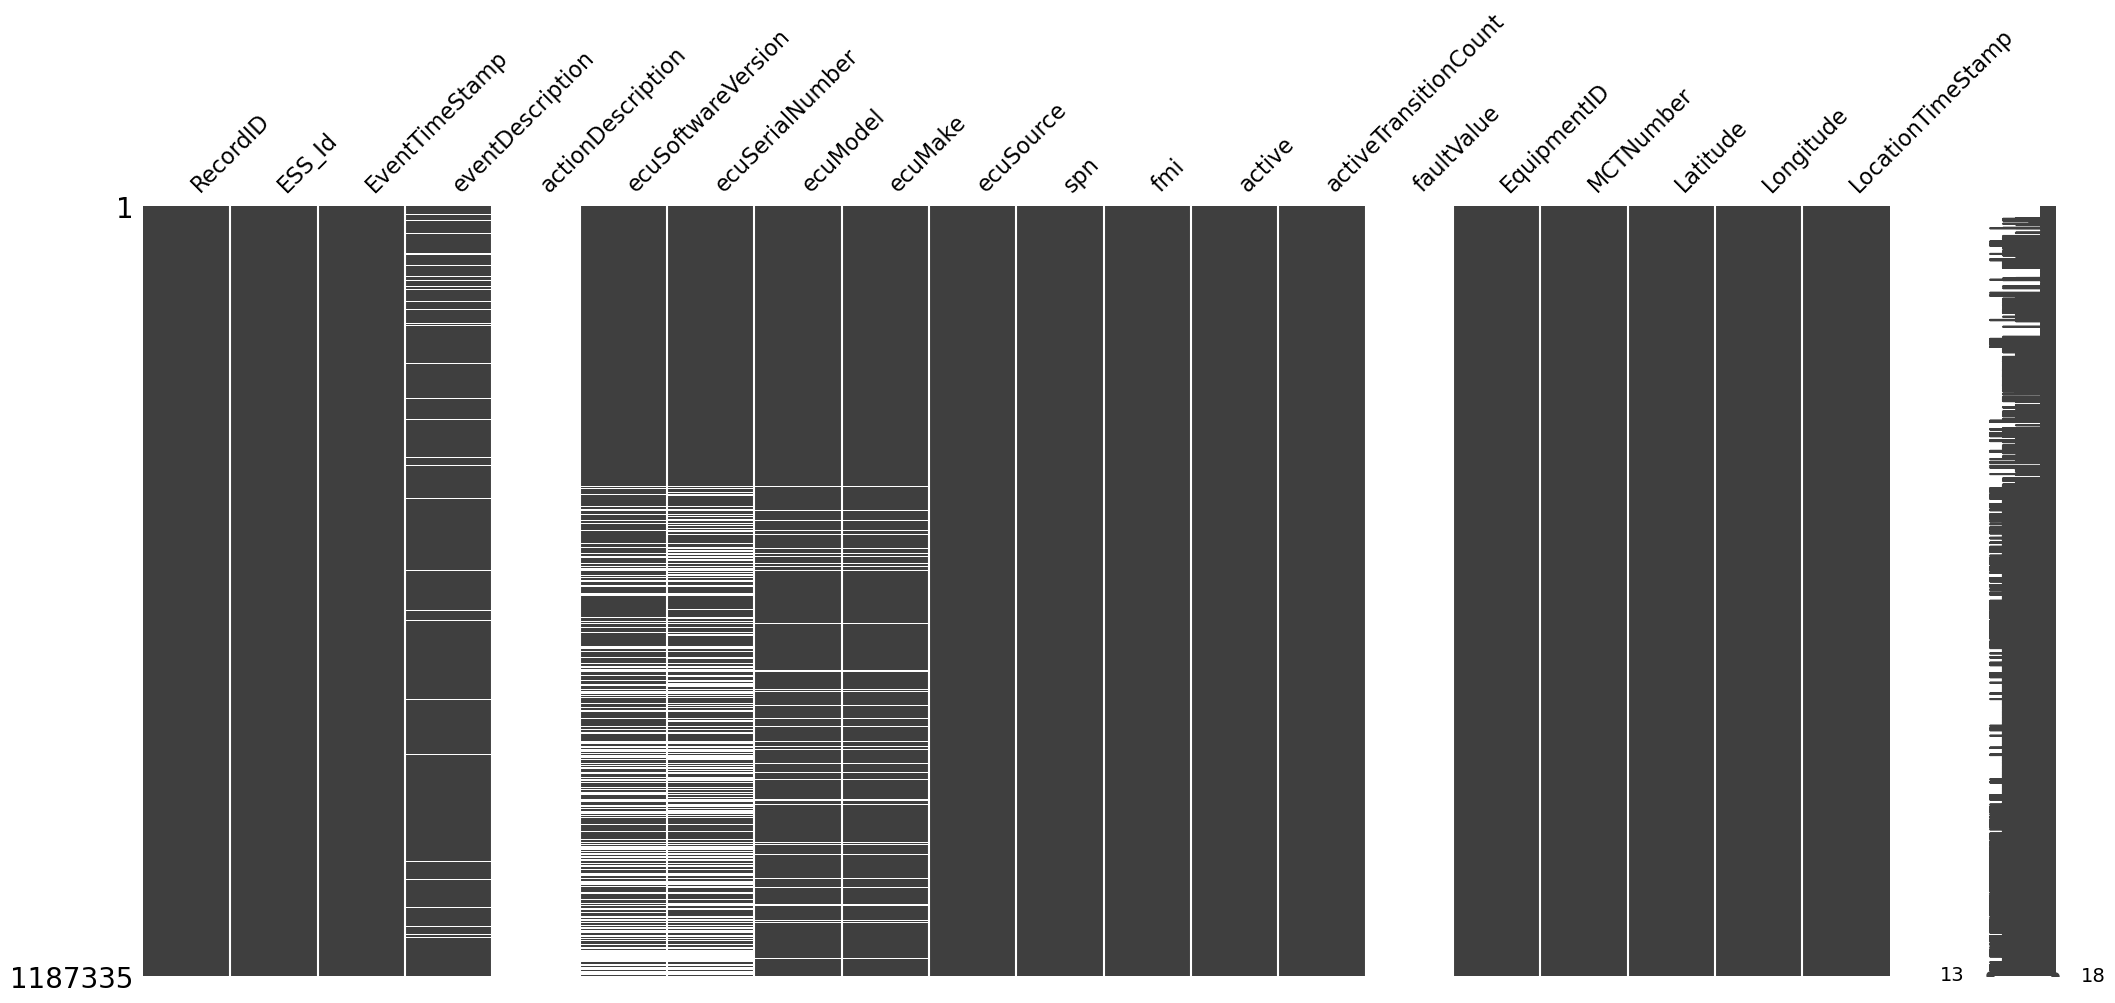

In [32]:
msno.matrix(faults);

In [19]:
faults.loc[0]

RecordID                                                       1
ESS_Id                                                    990349
EventTimeStamp                           2015-02-21 10:47:13.000
eventDescription         Low (Severity Low) Engine Coolant Level
actionDescription                                            NaN
ecuSoftwareVersion                                       unknown
ecuSerialNumber                                          unknown
ecuModel                                                 unknown
ecuMake                                                  unknown
ecuSource                                                      0
spn                                                          111
fmi                                                           17
active                                                      True
activeTransitionCount                                          2
faultValue                                                   NaN
EquipmentID              

Looking at the first record, here is a breakdown of the important values.

* ESS_Id, actionDescription, ecuSoftwareVersion, ecuSerialNumber, ecuModel, ecuMake, ecuSource, faultValue, and MCTNumber are unlikely to provide any predictive value.
* We can see the time of the event in the **EventTimeStamp** column. Note that this may be different from the **LocationTimeStamp** value, which indicates when the Latitude/Longitude values were recorded.
* The **spn** and **fmi** columns together indicate the type of fault, and there may be a description of that fault in the **eventDescription** column, although this column is sometimes missing.
* Faults are recorded when the light goes on and when it goes off, which is indicated by the **active** column, with True indicating the light turning on and False indicating turning off. The number of times the code has been set or unset is in the **faultValue** column, although this value can be unreliable. 
* Each truck has an identifier, the **EquipmentID** value.
* Each record can be linked to the on-board diagnostics data through the **RecordID** column.

In [48]:
faults[(faults.spn==5246)].count()

RecordID                 1195
ESS_Id                   1195
EventTimeStamp           1195
eventDescription            0
actionDescription           0
ecuSoftwareVersion       1005
ecuSerialNumber           975
ecuModel                  997
ecuMake                   997
ecuSource                1195
spn                      1195
fmi                      1195
active                   1195
activeTransitionCount    1195
faultValue                  0
EquipmentID              1195
MCTNumber                1195
Latitude                 1195
Longitude                1195
LocationTimeStamp        1195
dtype: int64

In [49]:
faults[((faults.spn==1569)&(faults.fmi==31))].count()

RecordID                 10927
ESS_Id                   10927
EventTimeStamp           10927
eventDescription         10927
actionDescription            0
ecuSoftwareVersion       10908
ecuSerialNumber          10665
ecuModel                 10665
ecuMake                  10665
ecuSource                10927
spn                      10927
fmi                      10927
active                   10927
activeTransitionCount    10927
faultValue                   0
EquipmentID              10927
MCTNumber                10927
Latitude                 10927
Longitude                10927
LocationTimeStamp        10927
dtype: int64

In [47]:
faults[((faults.spn==5246)) | ((faults.spn==1569)&(faults.fmi==31))].count()


RecordID                 12122
ESS_Id                   12122
EventTimeStamp           12122
eventDescription         10927
actionDescription            0
ecuSoftwareVersion       11913
ecuSerialNumber          11640
ecuModel                 11662
ecuMake                  11662
ecuSource                12122
spn                      12122
fmi                      12122
active                   12122
activeTransitionCount    12122
faultValue                   0
EquipmentID              12122
MCTNumber                12122
Latitude                 12122
Longitude                12122
LocationTimeStamp        12122
dtype: int64

In [6]:
diagnostics = pd.read_csv("../data/VehicleDiagnosticOnboardData.csv")

diagnostics.head()

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1


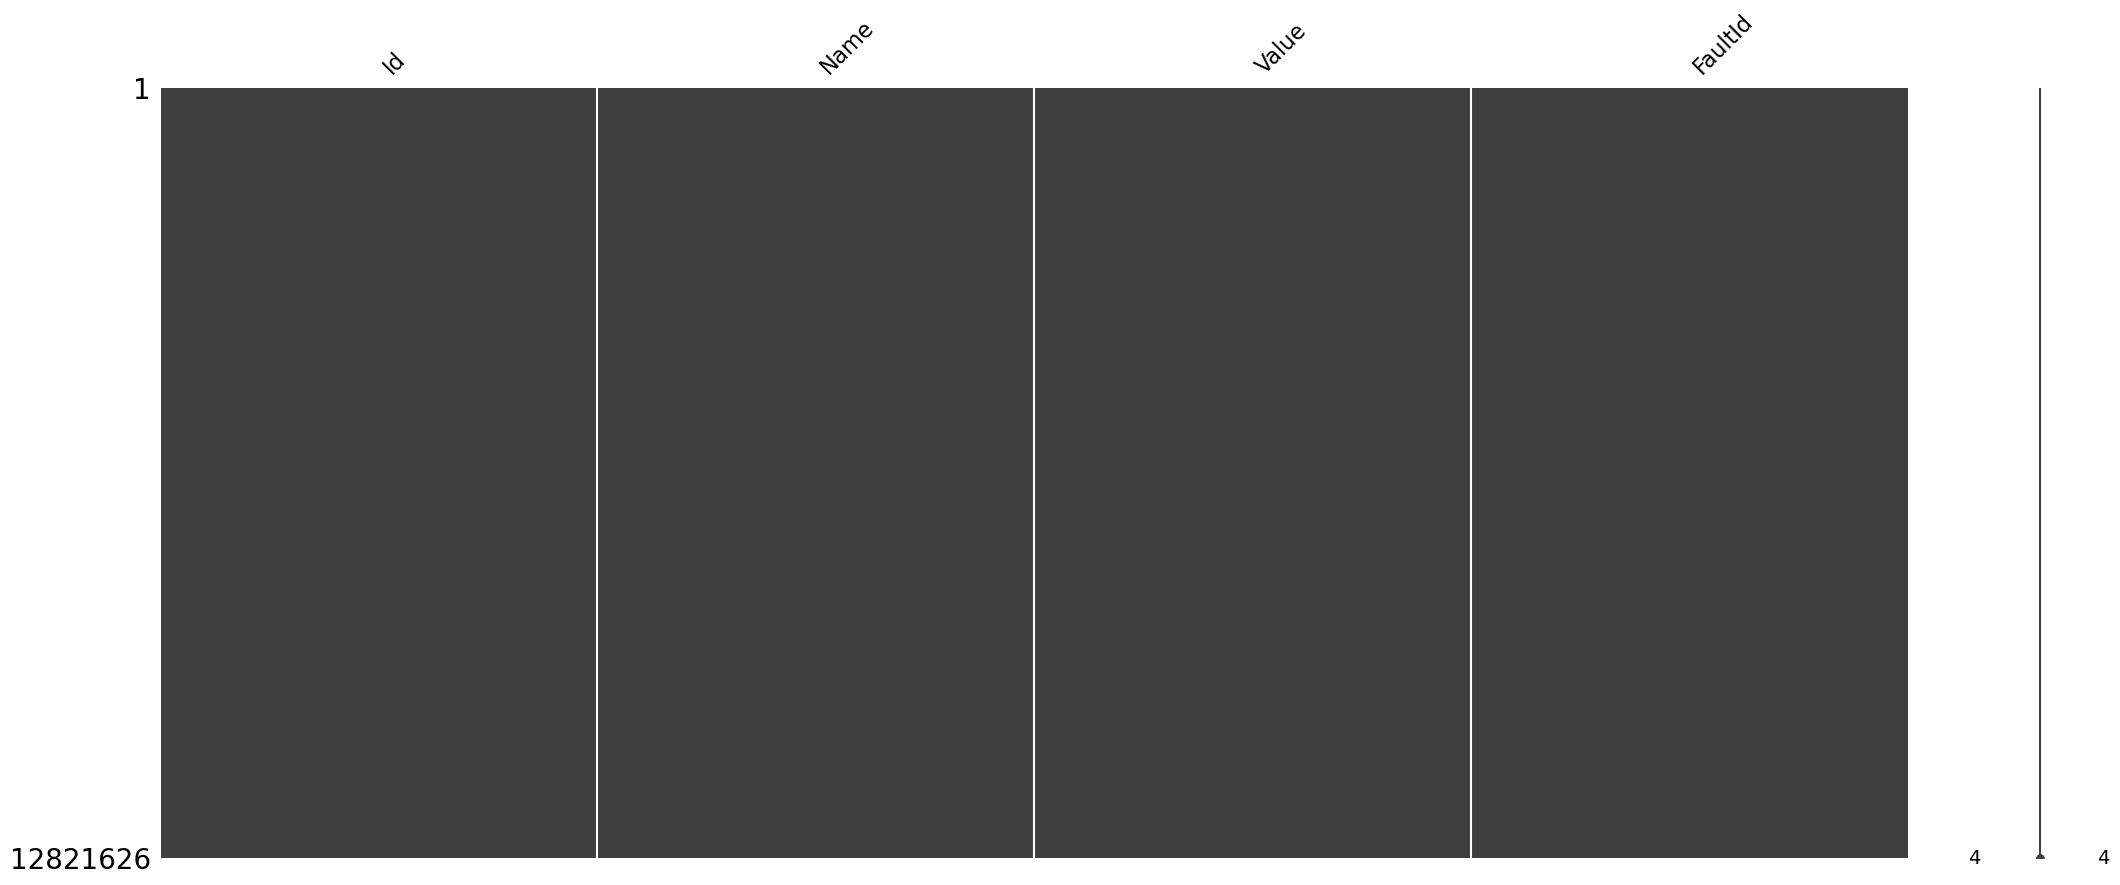

In [33]:
msno.matrix(diagnostics);

In [7]:
diagnostics[(diagnostics.FaultId == 10001)]

,Id,Name,Value,FaultId
94386,94387,IgnStatus,True,10001
94387,94388,EngineOilPressure,33.06,10001
94388,94389,EngineOilTemperature,218.975,10001
94389,94390,TurboBoostPressure,14.79,10001
94390,94391,AcceleratorPedal,94,10001
94391,94392,EngineLoad,61,10001
94392,94393,FuelLtd,71847.005068466,10001
94393,94394,IntakeManifoldTemperature,96.8,10001
94394,94395,FuelRate,10.91034,10001
94395,94396,LampStatus,2,10001


To get the on-board diagnostics at the time of the fault code, we can match the RecordID to the FaultId.

In [8]:
diagnostics.loc[diagnostics['FaultId'] == 1]

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1
5,6,AcceleratorPedal,0,1
6,7,IntakeManifoldTemperature,78.8,1
7,8,FuelRate,0,1
8,9,FuelLtd,12300.907429328,1
9,10,EngineRpm,0,1


Finally, we can get a little bit more information about the different fault codes from the Service Fault Codes spreadsheet.

In [9]:
sfc = pd.read_excel("../data/Service Fault Codes_1_0_0_167.xlsx")
sfc.head()

C:\Users\micha\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


,Published in CES 14602,Cummins Fault Code,Revision,PID,SID,MID,J1587 FMI,SPN,J1939 FMI,J2012 Pcode,Lamp Color,Lamp Device,Cummins Description,Algorithm Description
0,Y,111,167,Not Mapped,254,0,12,629,12,P0606,Red,Stop / Shutdown,Engine Control Module Critical Internal Failur...,Error internal to the ECM related to memory ha...
1,Y,112,167,Not Mapped,20,128,7,635,7,Not Mapped,Red,Stop / Shutdown,Engine Timing Actuator Driver Circuit - Mechan...,Mechanical failure in the engine timing actuat...
2,Y,113,167,Not Mapped,20,128,3,635,3,Not Mapped,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,High signal voltage detected at the engine tim...
3,Y,114,167,Not Mapped,20,128,4,635,4,Not Mapped,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,Low voltage detected at the engine timing actu...
4,Y,115,167,190,Not Mapped,Not Mapped,2,612,2,P0008,Red,Stop / Shutdown,Engine Magnetic Speed/Position Lost Both of Tw...,The ECM has detected that the primary and back...


In [10]:
sfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7124 entries, 0 to 7123
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Published in CES 14602  7124 non-null   object
 1   Cummins Fault Code      7124 non-null   int64 
 2   Revision                7124 non-null   int64 
 3   PID                     7124 non-null   object
 4   SID                     7124 non-null   object
 5   MID                     7124 non-null   object
 6   J1587 FMI               7124 non-null   int64 
 7   SPN                     7124 non-null   int64 
 8   J1939 FMI               7124 non-null   int64 
 9   J2012 Pcode             7124 non-null   object
 10  Lamp Color              7124 non-null   object
 11  Lamp Device             7124 non-null   object
 12  Cummins Description     7124 non-null   object
 13  Algorithm Description   2005 non-null   object
dtypes: int64(5), object(9)
memory usage: 779.3+ KB


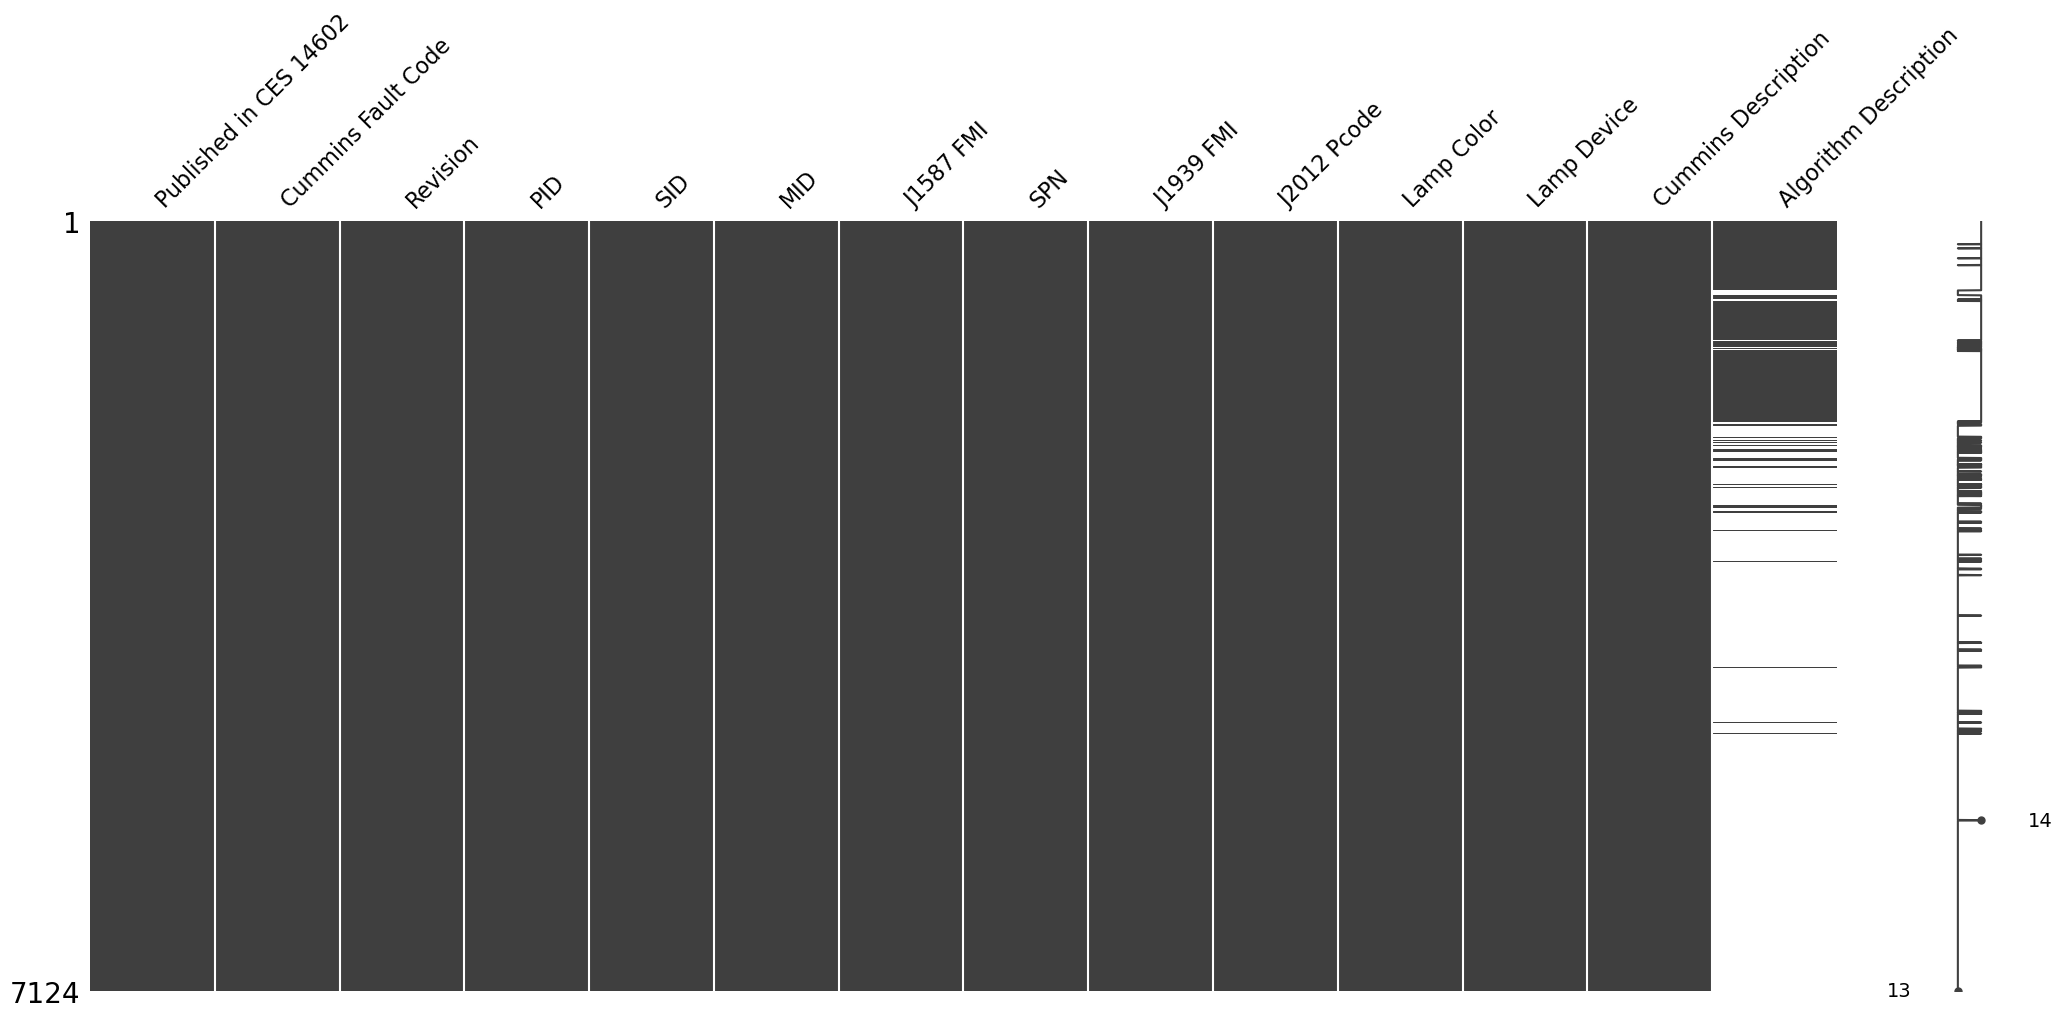

In [34]:
msno.matrix(sfc);

In [11]:
#get rid of the number of records with service center locations:
#(36.0666667, -86.4347222), (35.5883333, -86.4438888), (36.1950, -83.174722)
#drop service centers:
faults2=faults.drop(faults[(faults.Latitude==36.0666667) & (faults.Longitude ==-86.4347222)].index)
faults2=faults2.drop(faults2[(faults2.Latitude==35.5883333) & (faults2.Longitude ==-86.4438888)].index)
faults2=faults2.drop(faults2[(faults2.Latitude==36.1950) & (faults2.Longitude ==-83.174722)].index)

In [12]:
print(faults.shape)
print(faults2.shape)
#original was (1187335, 20)

(1187335, 20)
(1187260, 20)


* A 10 mile change in latitude is 0.144927536
* A 10 mile change in longitude is 0.128746217
* Strategy: Add and subtract to each lat on long of service stations.

In [13]:
#In (lat, lon) format
#Mt Juliet Location: (36.0666667, -86.4347222)

#(36.2115942, -86.4347222) #10 miles North
#(35.9217392, -86.4347222) #10 miles South
#(36.0666667, -86.305976) #10 miles East
#(36.0666667, -86.563468) #10 miles West
faults2=faults2[~((faults2['Latitude'] > 35.9217392) & (faults2['Latitude'] < 36.2115942) & 
                    (faults2['Longitude'] > -86.5485918) & (faults2['Longitude'] < -86.305976))]

In [14]:
print(faults.shape)
print(faults2.shape)

(1187335, 20)
(1084325, 20)


In [15]:
#Shelbyville location: (35.588333, -86.443888)

#North: (35.6382021, -86.443888)
#South: (35.5384639, -86.443888)
#East: (35.588333, -86.3391842)
#West: (35.588333, -86.5485918)
faults2=faults2[~((faults2['Latitude'] > 35.5384639) & (faults2['Latitude'] < 35.6382021) & 
                    (faults2['Longitude'] > -86.5485918) & (faults2['Longitude'] < -86.3391842))]


In [16]:
print(faults.shape)
print(faults2.shape)

(1187335, 20)
(1058870, 20)


In [17]:
#Russellville location: (36.1950, -83.174722)

#North: (36.2374703, -83.174722)
#South: (36.1525297, -83.174722)
#East: (36.195, -83.0693852)
#West: (36.195, -83.2800588)
faults2=faults2[~((faults2['Latitude'] > 36.2374703) & (faults2['Latitude'] < 36.1525297) & 
                    (faults2['Longitude'] > -83.2800588) & (faults2['Longitude'] < -83.0693852))]

In [18]:
print(faults.shape)
print(faults2.shape)

(1187335, 20)
(1058870, 20)


In [40]:
print((faults.spn==5246).count())
print((faults2.spn==5246).count())
print('---------')
print(((faults.spn==5246).count())-((faults2.spn==5246).count()))

1187335
1058870
---------
128465


In [42]:
faults2.to_csv('../data/faults_no_service_stations.csv')

##### You could:
  *  Pull out EquipmentID, RecordID, timestamp on every fault code that has a derate.
  *  Then look at all fault codes that are timestamped between 2 and 24 hours before, pulling ID data from there.
  *      (You might have to create your own unique index?)
  *  Then, run through diagnostics, pulling all data with correct RecordID
  *  Possible interesting columns:
  *      Number of records
  *      Number of faults
  *      Highly recurring faults(like top 10 or 20)
    

* QUESTION: How to incorporate false positives? via confusion_matrix? Note the weighting that can be used in the datacamp intermediate pipeline course...

#### Basic things:
    1. MT and PS push to github
    2. Any Q's for Michael
        * How much to cut out around service center?
    3. Convert from lat/lon to geopandas and make a circular fence around the service centers
    4. Start by looking at one truck with appropriate derate codes (faults[((faults.spn==5246)) | ((faults.spn==1569)&(faults.fmi==31))].count())


#### Strategic/Tactical considerations:
    1. Need to look at both the cost of derates and the cost of a false positive
    2. Perhaps focusing on features in the emissions, aka the aftertreatment system.